## Assignment for technical interview

Date Created: 24/03/2020 <br>
Created By: Himanshu Raj

### Problem Statement:

The problem is about natural language processing. It is based on a data set of 1,000 sentences in English, sampled from the Harry Potter book series, by J. K. Rowling. The task is to find any sentences that might be similar to a reference sentence with the id "1140".

The data is available at a Github repository: https://github.com/lassehjorthmadsen/data-science-assignment. It it located it the data folder in a csv-file called harry.csv.

### Approach:

In this solution we will try two methods of calculating the similarity of text: <br>

#### * Term Frequency-inverse document frequency (TF-idf): 
This looks at words that appear in both pieces of text, and scores them based on how often they appear.


##### * Semantic similarity: 
This scores words based on how similar they are, even if they are not exact matches. It borrows techniques from Natural Language Processing (NLP), such as word embeddings. This is useful if the word overlap between texts is limited.

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import threading
from multiprocessing import cpu_count
from PIL import Image
import requests
from wordcloud import WordCloud,ImageColorGenerator
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

<IPython.core.display.Javascript object>

[nltk_data] Downloading package wordnet to /Users/c305877/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Reading Data from source

In [2]:
url = 'https://github.com/lassehjorthmadsen/data-science-assignment/blob/master/data/harry.csv?raw=true'
data = pd.read_csv(url, encoding= 'unicode_escape')
print(data.head(5))

      id                                               text
0  36527  The last trace of steam evaporated in the autu...
1  36521  But how the doors were slamming all along the ...
2  36406  Haven't you noticed how none of the spells you...
3  36395  Harry watched with terror and elation as Molly...
4  36383  Harry pulled the Invisibility Cloak from insid...


#### Importing Stopwords and custom defining stopswords if required

In [3]:
stopwords = nltk.corpus.stopwords.words('english')
newFile = open(r"MyStopwords.txt", 'r')
myStopwords = newFile.read()
myStopwords = myStopwords.lower().split('\n')
stopwords.extend(myStopwords)

<IPython.core.display.Javascript object>

#### Data Preprocessing and Cleaning (Using Lemmetization)

In [4]:
def dataPrep(data):
    print(data.isnull().sum())
    data['cleaned_text'] = data['text'].str.lower()
    data['cleaned_text'] = data['cleaned_text'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    lem = WordNetLemmatizer()
    data['cleaned_text'] = data['cleaned_text'].apply(lambda x: " ".join([lem.lemmatize(i) for i in x.split() if i not in (stopwords)]))
    return data

In [5]:
dataPrep(data) # There are 0 empty values in the dataset

id      0
text    0
dtype: int64


,id,text,cleaned_text
0,36527,The last trace of steam evaporated in the autu...,last trace steam evaporated autumn air
1,36521,But how the doors were slamming all along the ...,door slamming along scarlet train blurred outl...
2,36406,Haven't you noticed how none of the spells you...,noticed none spell put binding
3,36395,Harry watched with terror and elation as Molly...,harry watched terror elation molly weasley's w...
4,36383,Harry pulled the Invisibility Cloak from insid...,harry pulled invisibility cloak inside robe sw...
...,...,...,...
995,78,"Trying to pull himself together, he let himsel...",trying pull together let house
996,19,"For a second, Mr. Dursley didn't realize what ...",second mr dursley realize seen jerked head aro...
997,18,It was on the corner of the street that he not...,corner street noticed first sign something pec...
998,16,"At half past eight, Mr. Dursley picked up his ...",half past eight mr dursley picked briefcase pe...


#### Exploring the frequest words using wordcloud

In [6]:
def visualsWordCloud(words, titleText):
    mask = np.array(Image.open(requests.get('http://clipart-library.com/data_images/224.jpg', stream=True).raw))
    image_colors = ImageColorGenerator(mask)
    wc = WordCloud(background_color='black', height=1500, width=4000,mask=mask).generate(words)
    plt.figure(figsize=(10,20))
    plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
    plt.title(titleText)
    plt.axis('off')
    plt.show()

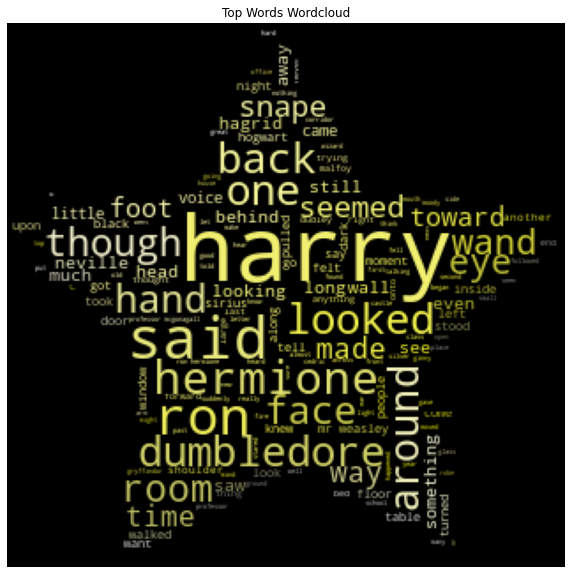

In [7]:
words = ' '.join(text for text in data['cleaned_text'])
visualsWordCloud(words, "Top Words Wordcloud")

#### Creating Query term and Cropus for the algorithms

In [8]:
search_param = data.loc[data['id'] == 1140]['cleaned_text'].values[0]
docs = data['cleaned_text'].values.tolist()
titles = data['id']

## TF-IDF Approach:

In [9]:
def rank_documents(search_terms: str, documents: list):
    vectorizer = TfidfVectorizer(stop_words=stopwords)
    try:
        vectors = vectorizer.fit_transform([search_terms] + documents)
        cosine_similarities = linear_kernel(vectors[0:1], vectors).flatten()
        document_scores = [item.item() for item in cosine_similarities[1:]]
    except ValueError:
        print(f'Unable to rank documents for search terms: {search_terms}')
        document_scores = [0. for _ in range(len(documents))]
    return document_scores

In [10]:
document_scores = rank_documents(search_param, docs)
score_titles = [(score, title) for score, title in zip(document_scores, titles)]

for score, title in (sorted(score_titles, reverse=True, key=lambda x: x[0])[:5]):
    print(f'{title} \t {score:0.3f}')

1140 	 1.000
35736 	 0.671
17285 	 0.266
2625 	 0.251
30890 	 0.206


In [11]:
# Therefore according to TF-IDF acore the most relevant text in corpus is:
print('The most relvant text in the corpus with the TF-IDF approach is "%s"' % data.loc[data['id'] == 35736]['text'].values[0])

The most relvant text in the corpus with the TF-IDF approach is "She glanced at him and then looked back out of the window."


## Semantic Matching Approach:

In [12]:
from re import sub
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

In [13]:
search_param = data.loc[data['id'] == 1140]['cleaned_text'].values[0]
docs = data['cleaned_text'].values.tolist()
titles = data['id']

In [14]:
def preprocess(doc):
    # Tokenize the input string for compatibility
    doc = sub(r'<[^<>]+(>|$)', " ", doc)
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf")) if token not in stopwords]

In [15]:
docs = [preprocess(document) for document in docs]
search_param = preprocess(search_param)

In [16]:
def rank_simimlar_docs(query: list, documents: list):
    if 'glove' not in locals():  # only load if not already in memory
        glove = api.load("glove-wiki-gigaword-50")  
    similarity_index = WordEmbeddingSimilarityIndex(glove)
    try:
        dictionary = Dictionary(documents+[query])
        tfidf = TfidfModel(dictionary=dictionary)
        similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)
        query_tf = tfidf[dictionary.doc2bow(search_param)]
        index = SoftCosineSimilarity(tfidf[[dictionary.doc2bow(document) for document in documents]],similarity_matrix)
    except ValueError:
        print(f'Unable to rank similar documnet for search terms: {query}')
    
    return index[query_tf]

In [17]:
doc_similarity_scores = rank_simimlar_docs(search_param, docs)
sorted_indexes = np.argsort(doc_similarity_scores)[::-1]
for idx in sorted_indexes[:15]:
    print(f'{idx} \t {titles[idx]} \t {doc_similarity_scores[idx]:0.3f}')

962 	 1140 	 1.000
17 	 35736 	 0.712
928 	 2486 	 0.668
776 	 8700 	 0.656
755 	 9546 	 0.629
351 	 23641 	 0.621
586 	 15749 	 0.618
993 	 134 	 0.616
630 	 13961 	 0.607
985 	 299 	 0.607
155 	 30369 	 0.605
523 	 17621 	 0.603
252 	 27265 	 0.603
380 	 22541 	 0.602
678 	 12183 	 0.602


In [18]:
# Therefore according to TF-IDF acore the most relevant text in corpus is:
print('Therefore according to Semantic Approach as well the most relvant text in the corpus is "%s"' % data.loc[data['id'] == 35736]['text'].values[0])

Therefore according to Semantic Approach as well the most relvant text in the corpus is "She glanced at him and then looked back out of the window."


### Conclusion

Using both the approach we found that <b>text referenced to id: 35736</b> (She glanced at him and then looked back out of the window.) <b>is the closest to query string i.e. id = 1140</b>